<a href="https://colab.research.google.com/github/umaa05/tugas_dl/blob/main/tugas_dl/TM4/pertama_dan_50Epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'vehicle-detection-image-set:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1329786%2F2214278%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240502%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240502T233711Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D14a06973d787b7e5d39fe5f3451c73d896cee0661e8ee0e51ba40386a0843648d0ae386db5e3cbc71459683c34d3755db43f756f7e7bce51bd6e02f153a01fe406d6df5e17b617b04c06e03a041d8bb49716b302594bfe1f8a213d813123a01b59c950eabd419d44e4fc97a50a791edfae0086a94fb630ca035edf20ccd26ebc5522afb9b08d54e7d285a8211416b53a90e7a495f287f00a833ef5bd112c49fca71c52eba54fdc3953191b1229526de45d812c8b4a6f509144428bbf063037ab69eb7deba423207f2d74528371c77f5192a30e9471d3d2c390e09c3eac4b93ddbd835af8632328efbdeaa3b316b718211b9041dc44a502cb39961133473d2d9f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 125013111 bytes downloaded
Downloaded and uncompressed: vehicle-detection-image-set
Data source import complete.


Import required liabraries

In [2]:
import pandas as pd
import numpy as np
import cv2
import random
import re
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Store a image data and shuffle it

In [3]:
i=0
labelname = []
images = []
images_path = []
images_pixels = []
labels =[]

In [4]:
path = "../input/vehicle-detection-image-set/data"
for directory in os.listdir(path):
    labelname.append(directory)
    for img in os.listdir(os.path.join(path,directory)):
        if len(re.findall('.png',img.lower())) != 0 or len(re.findall('.jpg',img.lower())) != 0 or len(re.findall('.jpeg',img.lower())) != 0:
            img_path = os.path.join(os.path.join(path,directory),img)
            images.append(img)
            images_path.append(img_path)
            img_pix = cv2.imread(img_path,1)
            images_pixels.append(cv2.resize(img_pix,(180,180)))
            labels.append(i)
    i= i+1

print("Total Labels: ", len(labels))
print("Total images: ", len(images))
print("Total output: ", len(labelname))
print("Total images_pixels: ", len(images_pixels))

Total Labels:  17760
Total images:  17760
Total output:  2
Total images_pixels:  17760


In [5]:
shuff = list(zip(images_pixels,labels))
random.shuffle(shuff)
train_data, labels_data = zip(*shuff)

array([[[120, 125, 132],
        [120, 125, 132],
        [121, 127, 134],
        ...,
        [ 38,  29,  31],
        [ 38,  29,  31],
        [ 38,  29,  31]],

       [[118, 123, 130],
        [118, 123, 130],
        [119, 125, 132],
        ...,
        [ 38,  29,  31],
        [ 38,  29,  31],
        [ 38,  29,  31]],

       [[101, 105, 112],
        [101, 106, 112],
        [103, 108, 114],
        ...,
        [ 36,  28,  30],
        [ 36,  28,  29],
        [ 36,  28,  29]],

       ...,

       [[ 94, 100, 107],
        [ 94, 100, 107],
        [ 94, 100, 107],
        ...,
        [ 76,  81,  91],
        [ 75,  80,  90],
        [ 75,  80,  90]],

       [[ 94, 100, 107],
        [ 94, 100, 107],
        [ 94, 100, 107],
        ...,
        [ 76,  79,  90],
        [ 76,  79,  89],
        [ 76,  79,  89]],

       [[ 94, 100, 107],
        [ 94, 100, 107],
        [ 94, 100, 107],
        ...,
        [ 76,  79,  90],
        [ 76,  79,  89],
        [ 76,  79,  89]]], dtype=uint8)
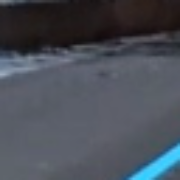

In [6]:
x_data = np.array(train_data)
x_data[0]

In [7]:
y_data = np.array(labels_data)
y_data[0:5]

array([1, 0, 1, 0, 1])

Plot sample images

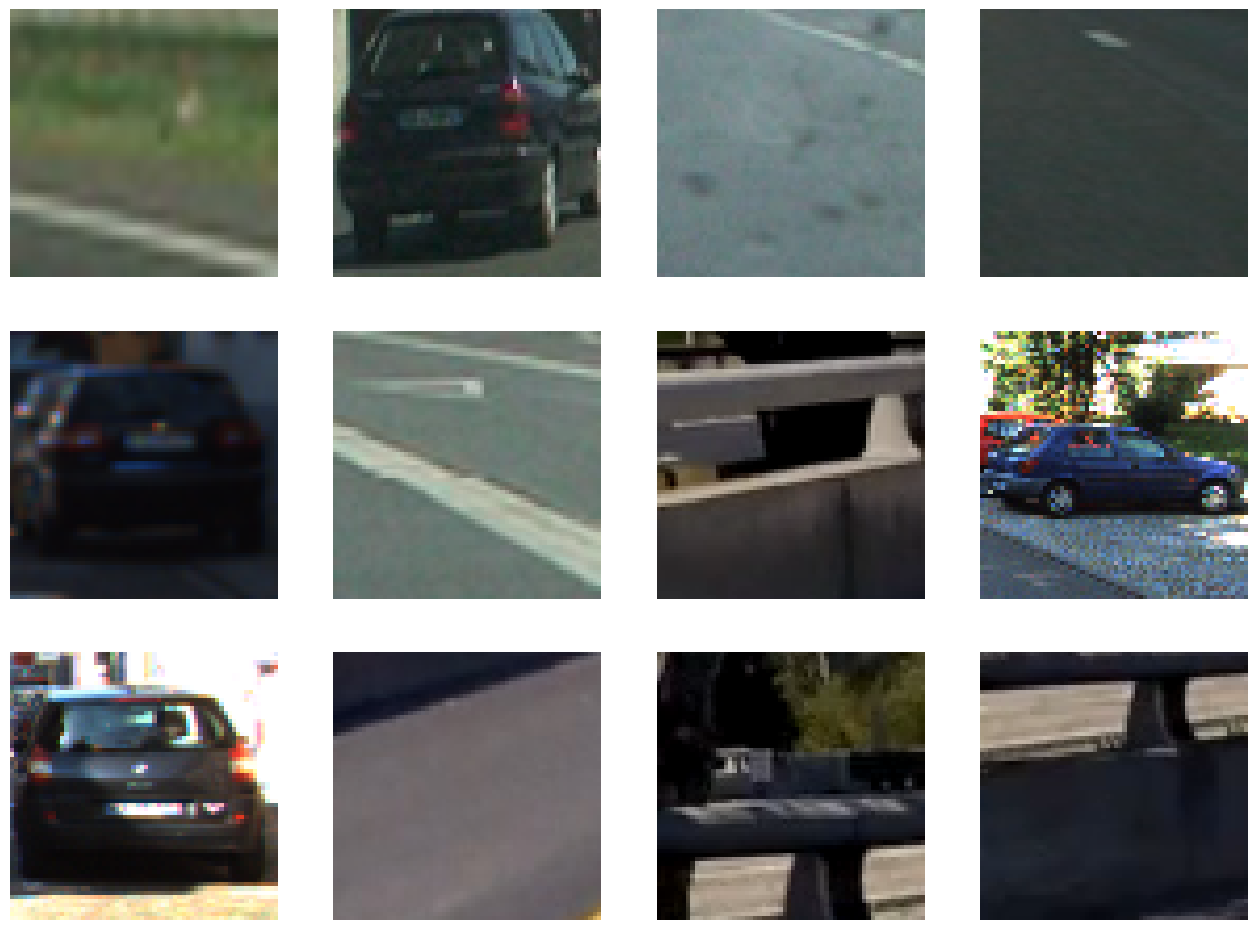

In [8]:

fig = plt.gcf()
fig.set_size_inches(16,16)

next_pix = images_path
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):

    sp=plt.subplot(4,4,i+1)
    sp.axis('off')

    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [9]:
print("X data shape : ", x_data.shape)
print("Y data shape : ", y_data.shape)

X data shape :  (17760, 180, 180, 3)
Y data shape :  (17760,)


Split the dataset with train_test_split method

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(x_data,y_data,test_size= 0.2, random_state=20)

print("X train data : ", len(X_train))
print("X label data : ", len(X_val))
print("Y test data : ", len(Y_train))
print("Y label data : ", len(Y_val))

X train data :  14208
X label data :  3552
Y test data :  14208
Y label data :  3552


Create a model

In [11]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',
                 activation ='relu', input_shape = (180,180,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))


Compile model

In [12]:
data_gen = ImageDataGenerator(rescale = 1/255.,
                              validation_split = 0.1,
                              zoom_range = 0.2,
                              horizontal_flip= True,
                              rotation_range = 20,
                              width_shift_range=0.2,
                              height_shift_range=0.2)

train_data = data_gen.flow_from_directory(path,
                                          target_size = (224, 224),
                                          batch_size = 64,
                                          subset = 'training',
                                          class_mode = 'binary')
val_data = data_gen.flow_from_directory(path,
                                        target_size = (224, 224),
                                        batch_size = 64,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 15985 images belonging to 2 classes.
Found 1775 images belonging to 2 classes.


Random changes on dataset and fit it on X_train

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

model_1 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2), # It will reduce the number of features by half
    Conv2D(filters = 32, kernel_size =2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_1.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(learning_rate = 0.001),
                metrics = ['accuracy'])

history_1 = model_1.fit(train_data,
                        epochs= 50,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/50
250/250 [==============================] - 240s 936ms/step - loss: 0.2868 - accuracy: 0.8808 - val_loss: 0.1716 - val_accuracy: 0.9555
Epoch 2/50
250/250 [==============================] - 232s 928ms/step - loss: 0.1760 - accuracy: 0.9337 - val_loss: 0.1215 - val_accuracy: 0.9718
Epoch 3/50
250/250 [==============================] - 232s 927ms/step - loss: 0.1357 - accuracy: 0.9505 - val_loss: 0.0594 - val_accuracy: 0.9814
Epoch 4/50
250/250 [==============================] - 229s 918ms/step - loss: 0.1197 - accuracy: 0.9558 - val_loss: 0.0961 - val_accuracy: 0.9758
Epoch 5/50
250/250 [==============================] - 228s 914ms/step - loss: 0.1094 - accuracy: 0.9615 - val_loss: 0.0381 - val_accuracy: 0.9876
Epoch 6/50
250/250 [==============================] - 248s 991ms/step - loss: 0.0965 - accuracy: 0.9652 - val_loss: 0.0475 - val_accuracy: 0.9887
Epoch 7/50
250/250 [==============================] - 228s 912ms/step - loss: 0.0925 - accuracy: 0.9678 - val_loss: 0.0478 -

Visulization of accuracy and loss

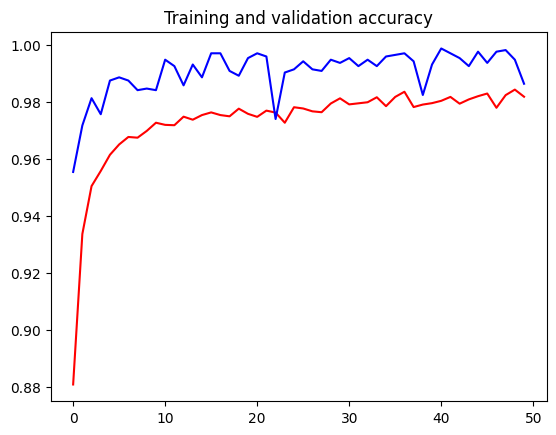

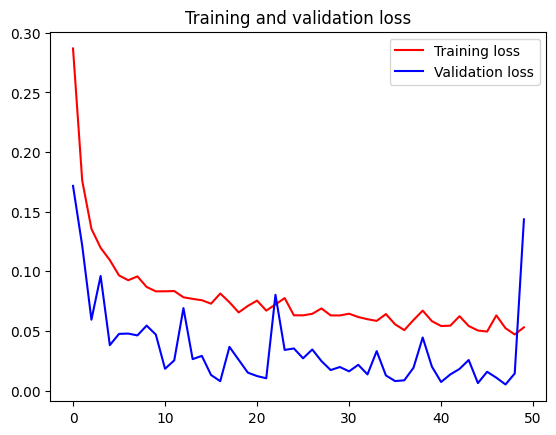

In [16]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label="Training accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
plt.title("Training and validation accuracy")

plt.figure()

plt.plot(epochs, loss, 'r', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [17]:
pred = model.predict(X_val)
pred

111/111 [==============================] - 1s 5ms/step


array([[0.05730461],
       [0.9953968 ],
       [0.995002  ],
       ...,
       [0.2198944 ],
       [0.11811645],
       [0.00168536]], dtype=float32)

In [18]:
test_path = "../input/vehicle-detection-image-set/data/non-vehicles/extra1001.png"
img_pix1 = cv2.imread(test_path,1)
resize_img_pix1 = cv2.resize(img_pix, (180,180))
rescale_img = np.array(resize_img_pix1) / 255
iimg = np.expand_dims(rescale_img, axis=0)
prediction = model.predict(iimg)

if prediction[0][0]  > 0.5:
    print("Vehical can not be detect")
else:
    print("Vehical detect")

1/1 [==============================] - 0s 232ms/step
Vehical detect
